# Get mode for each transcript

In [1]:
import pandas as pd
import sys
import pysam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pickle

In [2]:
global CACHE_CHROM
global CACHE_SAMFILE
CACHE_CHROM = None
CACHE_SAMFILE = None

def check_pysam_chrom(samFile, chrom=None):
    """Chech if samFile is a file name or pysam object, and if chrom format. 
    """
    global CACHE_CHROM
    global CACHE_SAMFILE

    if CACHE_CHROM is not None:
        if (samFile == CACHE_SAMFILE) and (chrom == CACHE_CHROM):
            return CACHE_SAMFILE, CACHE_CHROM

    if type(samFile) == str or type(samFile) == numpy.str_:
        ftype = samFile.split(".")[-1]
        if ftype != "bam" and ftype != "sam" and ftype != "cram" :
            print("Error: file type need suffix of bam, sam or cram.")
            sys.exit(1)
        if ftype == "cram":
            samFile = pysam.AlignmentFile(samFile, "rc")
        elif ftype == "bam":
            samFile = pysam.AlignmentFile(samFile, "rb")
        else:
            samFile = pysam.AlignmentFile(samFile, "r")

    if chrom is not None:
        if chrom not in samFile.references:
            if chrom.startswith("chr"):
                chrom = chrom.split("chr")[1]
            else:
                chrom = "chr" + chrom
        if chrom not in samFile.references:
            print("Can't find references %s in samFile" %chrom)
            return samFile, None

    CACHE_CHROM = chrom
    CACHE_SAMFILE = samFile
    return samFile, chrom

In [3]:
def load_samfile(samFile, chrom=None):
    """Chech if samFile is a file name or pysam object, and if chrom format.
    """
    print('Warning: The load_samfile() function is recommended to be ' + 
          'replaced by check_pysam_chrom().')

    global CACHE_CHROM
    global CACHE_SAMFILE

    # get from cache
    if CACHE_CHROM is not None:
        if (samFile == CACHE_SAMFILE) and (chrom == CACHE_CHROM):
            return CACHE_SAMFILE, CACHE_CHROM

    # open file
    if type(samFile) == str or type(samFile) == numpy.str_:
        ftype = samFile.split(".")[-1]
        if ftype != "bam" and ftype != "sam" and ftype != "cram" :
            print("Error: file type need suffix of bam, sam or cram.")
            sys.exit(1)
        if ftype == "cram":
            samFile = pysam.AlignmentFile(samFile, "rc")
        elif ftype == "bam":
            samFile = pysam.AlignmentFile(samFile, "rb")
        else:
            samFile = pysam.AlignmentFile(samFile, "r")
    else:
        print("[BRIE2] Error: unknown data type: %s" %samFile)
        print(type(samFile), type(samFile) == numpy.str_)
        sys.exit(1)

    if chrom is not None:
        if chrom not in samFile.references:
            if chrom.startswith("chr"):
                chrom = chrom.split("chr")[1]
            else:
                chrom = "chr" + chrom
        if chrom not in samFile.references:
            print("Can't find references %s in samFile" %chrom)
            return samFile, None

        CACHE_CHROM = chrom
        CACHE_SAMFILE = samFile
        return samFile, chrom
    else:
        CACHE_SAMFILE = samFile
        return samFile

In [4]:
def fetch_reads(samfile, chrom, start, end, rm_duplicate=True, inner_only=True,
                mapq_min=0, trimLen_max=1e6, rlen_min=1,  is_mated=True):
    """To fetch the reads in a given region from a pysam AlignmentFile.

    Args:
        samfile: A Samfile object in pysam.
        chrom: A string of chromosome, e.g., "IV", "chr10".
        start: An integer of the start position for mapped reads.
        end: An integer of the end position for mapped reads.
        rm_duplicate: A bool for only keeping the first one of duplicates.
        inner_only: A bool for only keeping fully region matched reads.
        mapq_min: An integer of the minimum of map quality.
        trimLen_max: An integer of the maximum length of trimmed bases.
        rlen_min: An integer of the minimum of read length.
        is_paired: A bool for mating paired-end reads.

    Returns:
        A dict containing lists of mated reads1 and reads2, and unmated reads1u
        and reads2u, i.e.,
        {'reads1': [r11, r21, ...]
         'reads2': [r12, r22, ...]
         'reads1u': [r*1, r*1, ...]
         'reads2u': [r*2, r*2, ...]}
        reads1 is the 5-end of the fragment, and reads2 is the 3-end of the 
        fragment.

    Raises:
        ValueError: An error occurred when fetching reads.
        AssertionError: An error occurred when fetching reads.
    """
    #part 1. check the input and fetch the reads
    chrom  = str(chrom)
    if chrom in samfile.references:
        pass
    else:
        chrom_parts = chrom.split("chr")
        if len(chrom_parts) <= 1:
            chrom = chrom_parts[0]
        else:
            chrom = chrom_parts[1]

    try:
        reads = samfile.fetch(chrom, start, end)
    except ValueError:
        reads = []
        print("Cannot fetch reads in region: %s:%d-%d" %(chrom, start, end))
    except AssertionError:
        reads = []
        print("AssertionError in region: %s:%d-%d" %(chrom, start, end))
        print(" - Check that your BAM file is indexed!")

    #part 2. get reads and filter some of them
    qname1, qname2 = [], []
    reads1, reads2 = [], []
    r_prev = None
    for r in reads:
        # filter 4: only keep the first one of duplicates
        if (rm_duplicate and r_prev is not None and r_prev.qname == r.qname and 
            r_prev.positions == r.positions): r_prev = r; continue
        r_prev = r
        # filter 1: only particially mapped to the regions
        if inner_only == True and (r.pos is None or r.pos < start or 
                                   r.aend is None or r.aend > end): continue
        # filter 2: too low map quality
        if r.mapq < mapq_min: continue
        # filter 3: too long trimmed bases
        if r.rlen - len(r.positions) > trimLen_max: continue
        # filter 5: too short mapped length
        if len(r.positions) < rlen_min: continue
        
        if r.is_read2:
            reads2.append(r)
            qname2.append(r.qname)
        else:
            reads1.append(r)
            qname1.append(r.qname)

    #part 2.1 chech the mate reads' query
    FLAG = True
    if len(qname1) > 0:
        for i in range(len(qname1)-1):
            if qname1[i][-1] != qname1[i+1][-1]:
                FLAG = False
                break
    if FLAG and len(qname2) > 0:
        for i in range(len(qname1)-1):
            if qname1[i][-1] != qname1[i+1][-1]:
                FLAG = False
                break

    if FLAG:
        for i in range(len(qname1)):
            qname1[i] = qname1[i][:-1]
        for i in range(len(qname2)):
            qname2[i] = qname2[i][:-1]


    # part 3. mate the reads
    rv_reads1, rv_reads2 = [], []
    rv_reads1u, rv_reads2u = [], []
    if is_mated == True:
        idx1 = sorted(range(len(qname1)), key=qname1.__getitem__)
        idx2 = sorted(range(len(qname2)), key=qname2.__getitem__)

        i1, i2 = 0, 0
        while i1 < len(idx1) and i2 < len(idx2):
            if qname1[idx1[i1]] == qname2[idx2[i2]]:
                rv_reads1.append(reads1[idx1[i1]])
                rv_reads2.append(reads2[idx2[i2]])
                i1, i2 = i1 + 1, i2 + 1
            elif qname1[idx1[i1]] < qname2[idx2[i2]]:
                rv_reads1u.append(reads1[idx1[i1]])
                i1 += 1
            elif qname1[idx1[i1]] > qname2[idx2[i2]]:
                rv_reads2u.append(reads2[idx2[i2]])
                i2 += 1
        for i in range(i1, len(idx1)):
            rv_reads1u.append(reads1[idx1[i]])
        for i in range(i2, len(idx2)):
            rv_reads2u.append(reads2[idx2[i]])
    else:
        rv_reads1u, rv_reads2u = reads1, reads2

    # part 4. return reads
    RV = {}
    RV["reads1"] = rv_reads1
    RV["reads2"] = rv_reads2
    RV["reads1u"] = rv_reads1u
    RV["reads2u"] = rv_reads2u
    return RV

In [5]:

transcriptdf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/annotation/annotation_from_Gencode/transcript.bed',delimiter='\t',header=None)
transcriptdf.columns=['chr','start','end','score','strand','transcript_id','gene_id']
transcriptdf

,chr,start,end,score,strand,transcript_id,gene_id
0,chr1,11868,14409,.,+,ENST00000456328.2,ENSG00000290825.1
1,chr1,12009,13670,.,+,ENST00000450305.2,ENSG00000223972.6
2,chr1,29553,31097,.,+,ENST00000473358.1,ENSG00000243485.5
3,chr1,30266,31109,.,+,ENST00000469289.1,ENSG00000243485.5
4,chr1,30365,30503,.,+,ENST00000607096.1,ENSG00000284332.1
...,...,...,...,...,...,...,...
252830,chrY,57015104,57016096,.,-,ENST00000711258.1,ENSG00000292364.1
252831,chrY,57165511,57165845,.,-,ENST00000711266.1,ENSG00000292367.1
252832,chrY,57171889,57172769,.,-,ENST00000711267.1,ENSG00000292368.1
252833,chrY,57201142,57203357,.,-,ENST00000711269.1,ENSG00000292370.1


In [6]:
transcriptdf['PAS']=np.where(transcriptdf['strand']=='+',transcriptdf['end'],transcriptdf['start'])
transcriptdf

,chr,start,end,score,strand,transcript_id,gene_id,PAS
0,chr1,11868,14409,.,+,ENST00000456328.2,ENSG00000290825.1,14409
1,chr1,12009,13670,.,+,ENST00000450305.2,ENSG00000223972.6,13670
2,chr1,29553,31097,.,+,ENST00000473358.1,ENSG00000243485.5,31097
3,chr1,30266,31109,.,+,ENST00000469289.1,ENSG00000243485.5,31109
4,chr1,30365,30503,.,+,ENST00000607096.1,ENSG00000284332.1,30503
...,...,...,...,...,...,...,...,...
252830,chrY,57015104,57016096,.,-,ENST00000711258.1,ENSG00000292364.1,57015104
252831,chrY,57165511,57165845,.,-,ENST00000711266.1,ENSG00000292367.1,57165511
252832,chrY,57171889,57172769,.,-,ENST00000711267.1,ENSG00000292368.1,57171889
252833,chrY,57201142,57203357,.,-,ENST00000711269.1,ENSG00000292370.1,57201142


In [7]:
bamFile='/mnt/ruiyanhou/nfs_share2/three_primer/PBMC/preprocess/STAR_output/PBMC866_umitools_filtered.bam'

In [8]:
reads1_paired_fragement_mode_ls=[]
reads2_paired_fragement_mode_ls=[]
reads1_unique_fragement_mode_ls=[]
reads2_unique_fragement_mode_ls=[]

for index,row in transcriptdf.iterrows():
    samFile, _chrom = check_pysam_chrom(bamFile, row['chr'])
    reads = fetch_reads(samFile, _chrom,  row['start'] , row['end'],  trimLen_max=100)

    reads1_paired=reads['reads2']
    reads2_paired=reads['reads1']
    reads1_unique=reads['reads2u']
    reads2_unique=reads['reads1u']


    gene_reads1_paired=[read for read in reads1_paired if read.get_tag('GX')==row['gene_id']]
    gene_reads2_paired=[read for read in reads2_paired if read.get_tag('GX')==row['gene_id']]
    gene_reads1_unique=[read for read in reads1_unique if read.get_tag('GX')==row['gene_id']]
    gene_reads2_unique=[read for read in reads2_unique if read.get_tag('GX')==row['gene_id']]

    #print('{} reads1 in pair; {} reads2 in pair; {} reads1 is unique; {} reads2 is unique'.format(len(gene_reads1_paired),len(gene_reads2_paired),len(gene_reads1_unique),len(gene_reads2_unique)))


    if len(gene_reads1_paired)>20:

        if row['strand']=='+':
            reads1_paired_fragement=[read.reference_end-row['PAS'] for read in gene_reads1_paired]
            reads2_paired_fragement=[read.reference_end-row['PAS'] for read in gene_reads2_paired]
            reads1_unique_fragement=[read.reference_end-row['PAS'] for read in gene_reads1_unique]
            reads2_unique_fragement=[read.reference_end-row['PAS'] for read in gene_reads2_unique]
            
        elif row['strand']=='-':
            reads1_paired_fragement=[row['PAS']-read.reference_start for read in gene_reads1_paired]
            reads2_paired_fragement=[row['PAS']-read.reference_start for read in gene_reads2_paired]
            reads1_unique_fragement=[row['PAS']-read.reference_start for read in gene_reads1_unique]
            reads2_unique_fragement=[row['PAS']-read.reference_start for read in gene_reads2_unique]
    
    
        reads1_paired_fragement_mode=stats.mode(reads1_paired_fragement)[0]
        reads2_paired_fragement_mode=stats.mode(reads2_paired_fragement)[0]
        reads1_unique_fragement_mode=stats.mode(reads1_unique_fragement)[0]
        reads2_unique_fragement_mode=stats.mode(reads2_unique_fragement)[0]
    
        
        reads1_paired_fragement_mode_ls.append(reads1_paired_fragement_mode)
        reads2_paired_fragement_mode_ls.append(reads2_paired_fragement_mode)
        reads1_unique_fragement_mode_ls.append(reads1_unique_fragement_mode)
        reads2_unique_fragement_mode_ls.append(reads2_unique_fragement_mode)
        

In [9]:
readsdict={}
readsdict['reads1_paired']=reads1_paired_fragement_mode_ls
readsdict['reads2_paired']=reads2_paired_fragement_mode_ls
readsdict['reads1_unique']=reads1_unique_fragement_mode_ls
readsdict['reads2_unique']=reads2_unique_fragement_mode_ls

In [10]:
with open('/mnt/ruiyanhou/nfs_share2/three_primer/plot_coverage/density_plot/all_mode.pkl','wb') as f:
    pickle.dump(readsdict,f)

# plot

In [11]:
import pandas as pd
import pickle
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
with open('/mnt/ruiyanhou/nfs_share2/three_primer/plot_coverage/density_plot/all_mode.pkl','rb') as f:
    mymode=pickle.load(f)
    

In [13]:
reads1_paired=mymode['reads2_paired']
reads1_paired

[-10,
 -43,
 -5,
 -13,
 -40,
 -11,
 0,
 -5061,
 -4700,
 -2861,
 -4947,
 -26,
 -5023,
 -13,
 -3520,
 -16,
 -2,
 -9,
 -38,
 -11,
 0,
 -2753,
 -2861,
 -2805,
 -26,
 -2,
 -37,
 -2,
 -38,
 -2803,
 0,
 -6,
 -6,
 -1352,
 -11,
 -10,
 -3,
 -26,
 -26,
 -26,
 -26,
 -26,
 -6,
 -23,
 -26,
 -9,
 -23,
 -12,
 -26,
 -1653,
 -6,
 -1653,
 -7,
 -6,
 -3,
 -3,
 -3,
 -256,
 -1452,
 -9,
 -9,
 -10,
 -10,
 -10,
 -10,
 -9,
 -1897,
 -7727,
 -9,
 -7519,
 -9,
 -585,
 -10,
 -7588,
 -9,
 -11850,
 -9,
 -9,
 -12,
 -8,
 -10,
 -29,
 -24,
 -29,
 -27,
 -105,
 -1689,
 -1683,
 -548,
 -7,
 -18,
 -6,
 -17,
 -26,
 -26,
 -26,
 -101,
 -101,
 -21,
 -98,
 -1654,
 -12,
 -12,
 -13,
 -12,
 -8,
 -14,
 -13,
 -2,
 -28,
 -15630,
 -15657,
 -19,
 -14,
 -4,
 -7429,
 -7447,
 -2,
 -14218,
 -14262,
 -4,
 -20604,
 -23719,
 -16,
 -11582,
 -4,
 -11577,
 -6,
 -16380,
 -11574,
 -23772,
 -26310,
 -6,
 -14227,
 -11574,
 -26313,
 -6,
 -5,
 -23424,
 -23934,
 -11573,
 -6,
 -12722,
 -24066,
 -25234,
 -12722,
 -6,
 -13,
 -31,
 -31,
 -31,
 -31,
 -5,
 -2029,

In [14]:
reads2_paired=mymode['reads1_paired']
reads2_paired

[-162,
 -175,
 -280,
 -71,
 -225,
 -123,
 -12554,
 -5173,
 -4812,
 -2973,
 -5059,
 -138,
 -5135,
 -125,
 -3632,
 -128,
 -114,
 -121,
 -150,
 -123,
 -12554,
 -2865,
 -2973,
 -2917,
 -138,
 -114,
 -149,
 -114,
 -150,
 -2915,
 -12554,
 -151,
 -151,
 -1539,
 -124,
 -123,
 -70,
 -184,
 -184,
 -184,
 -184,
 -184,
 -66,
 -181,
 -184,
 -117,
 -181,
 -120,
 -184,
 -1793,
 -146,
 -1793,
 -147,
 -146,
 -145,
 -145,
 -145,
 -340,
 -1536,
 -85,
 -85,
 -76,
 -76,
 -76,
 -76,
 -85,
 -2069,
 -7899,
 -85,
 -7691,
 -85,
 -757,
 -182,
 -7760,
 -85,
 -12022,
 -85,
 -85,
 -60,
 -84,
 -76,
 -137,
 -132,
 -137,
 -135,
 -108,
 -2307,
 -2301,
 -616,
 -84,
 -95,
 -163,
 -128,
 -120,
 -120,
 -120,
 -264,
 -264,
 -184,
 -261,
 -1817,
 -157,
 -157,
 -158,
 -157,
 -128,
 -159,
 -158,
 -481,
 -507,
 -71566,
 -71593,
 -150,
 -177,
 -135,
 -63365,
 -63383,
 -55938,
 -70154,
 -70198,
 -135,
 -76540,
 -79655,
 -147,
 -67518,
 -135,
 -11723,
 -137,
 -16526,
 -11720,
 -23918,
 -26456,
 -137,
 -14373,
 -11720,
 -26459,
 -1

In [15]:
reads1_unique=mymode['reads2_unique']
reads1_unique

[-8,
 -16,
 nan,
 nan,
 -36,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -40,
 -40,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -13,
 -13,
 -14,
 -14,
 -14,
 -14,
 -13,
 nan,
 nan,
 -13,
 nan,
 -13,
 nan,
 nan,
 nan,
 -13,
 -12627,
 -13,
 -13,
 -17,
 -12,
 -14,
 -8,
 -3,
 -8,
 -6,
 -110,
 -1697,
 -1691,
 -6,
 -13,
 -24,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -3593,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -32,
 -27,
 -17,
 nan,
 nan,
 nan,
 -70092,
 -70140,
 -82267,
 -76482,
 -79597,
 -82279,
 -67460,
 -17,
 nan,
 -19,
 nan,
 nan,
 nan,
 nan,
 -19,
 nan,
 nan,
 nan,
 -15960,
 -15959,
 -12993,
 -13503,
 -1142,
 -15970,
 -2301,
 -13645,
 -14813,
 -2301,
 -19,
 -26,
 nan,
 nan,
 nan,
 -6,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 

In [16]:
reads2_unique=mymode['reads1_unique']
reads2_unique

[-196,
 -177,
 -973,
 -143,
 -225,
 -12471,
 -12460,
 -17521,
 -17160,
 -15321,
 -17407,
 -12486,
 -17483,
 -12473,
 -15980,
 -12476,
 -12462,
 -12469,
 -12498,
 -12471,
 -12460,
 -15213,
 -15321,
 -15265,
 -12486,
 -12462,
 -12497,
 -12462,
 -12498,
 -15263,
 -12460,
 -151,
 -151,
 nan,
 -313,
 -312,
 -47,
 -207,
 -207,
 -207,
 -207,
 -207,
 -121,
 -204,
 -207,
 -67,
 -204,
 -127,
 -207,
 -1907,
 -260,
 -1907,
 -261,
 -260,
 -11911,
 -11911,
 -11911,
 -368,
 -1564,
 -75,
 -75,
 -231,
 -231,
 -231,
 -231,
 -75,
 -2053,
 -7883,
 -75,
 -7675,
 -75,
 -741,
 -166,
 -7744,
 -75,
 -12006,
 -75,
 -75,
 -60,
 -74,
 -231,
 -272,
 -267,
 -272,
 -270,
 -120,
 -2322,
 -2316,
 -631,
 -96,
 -107,
 -147,
 -158,
 -1126,
 -1126,
 -1126,
 -214,
 -214,
 -23,
 -211,
 -1767,
 -252,
 -252,
 -229,
 -252,
 -248,
 -230,
 -229,
 -511,
 -537,
 -82881,
 -82908,
 -150,
 -145,
 -135,
 -74680,
 -74698,
 -67253,
 -81469,
 -81513,
 -135,
 -87855,
 -90970,
 -147,
 -78833,
 -135,
 -12283,
 -137,
 -17086,
 -12280,
 -2447

In [17]:
filtered_reads1_paired=[x for x in reads1_paired if not math.isnan(x)]
filtered_reads2_paired=[x for x in reads2_paired if not math.isnan(x)]
filtered_reads1_unique=[x for x in reads1_unique if not math.isnan(x)]
filtered_reads2_unique=[x for x in reads2_unique if not math.isnan(x)]


In [18]:
select_filtered_reads1_paired=[read for read in filtered_reads1_paired if read>-500]
select_filtered_reads2_paired=[read for read in filtered_reads2_paired if read>-500]
select_filtered_reads1_unique=[read for read in filtered_reads1_unique if read>-500]
select_filtered_reads2_unique=[read for read in filtered_reads2_unique if read>-500]

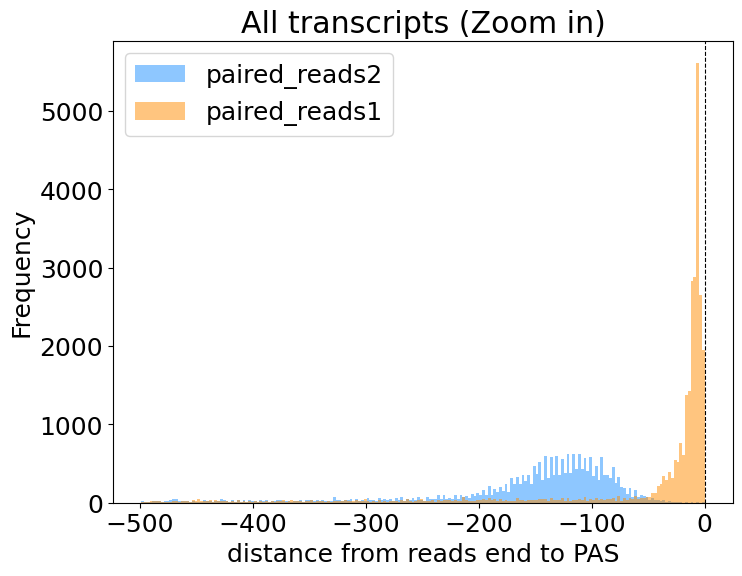

In [19]:
plt.rcParams['font.size'] = 18

fig,ax=plt.subplots(figsize=(8,6))
# sns.kdeplot(np.array(select_filtered_reads1_unique), bw=0.5,color='green',label='unique_reads1')
# sns.kdeplot(np.array(select_filtered_reads2_unique), bw=0.5,color='red',label='unique_reads2')
plt.hist(np.array(select_filtered_reads2_paired), color='dodgerblue',label='paired_reads2',alpha=0.5,bins=200)
plt.hist(np.array(select_filtered_reads1_paired), color='darkorange',label='paired_reads1',alpha=0.5,bins=200)

plt.xlabel("distance from reads end to PAS")
plt.ylabel('Frequency')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

plt.title("All transcripts (Zoom in)")

ax.axvline(x=0, color='black', linestyle='--',lw=0.8)  
plt.legend()

#plt.savefig('/mnt/ruiyanhou/nfs_share2/three_primer/figure/figure1_histogram.pdf',dpi=300,bbox_inches='tight')
#genetitle=row['gene_name']+' '+'('+row['Strand']+')'+'Zoom in'
#plt.title(genetitle)
plt.show()